<a href="https://colab.research.google.com/github/Shalu31/solar-predictive-maintenance-ml-/blob/main/predectivemaintainforsolar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

In [4]:
df = pd.read_csv("/content/Plant_1_Generation_Data.csv")

In [5]:
df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [6]:
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df = df.sort_values('DATE_TIME').reset_index(drop=True)

/tmp/ipython-input-597861384.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])


In [7]:
df['hour'] = df['DATE_TIME'].dt.hour
df['day'] = df['DATE_TIME'].dt.day
df['month'] = df['DATE_TIME'].dt.month

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    68778 non-null  datetime64[ns]
 1   PLANT_ID     68778 non-null  int64         
 2   SOURCE_KEY   68778 non-null  object        
 3   DC_POWER     68778 non-null  float64       
 4   AC_POWER     68778 non-null  float64       
 5   DAILY_YIELD  68778 non-null  float64       
 6   TOTAL_YIELD  68778 non-null  float64       
 7   hour         68778 non-null  int32         
 8   day          68778 non-null  int32         
 9   month        68778 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(3), int64(1), object(1)
memory usage: 4.5+ MB


In [9]:
df.isnull().sum()

,0
DATE_TIME,0
PLANT_ID,0
SOURCE_KEY,0
DC_POWER,0
AC_POWER,0
DAILY_YIELD,0
TOTAL_YIELD,0
hour,0
day,0
month,0


In [10]:
df['rolling_dc'] = (
    df.groupby('SOURCE_KEY')['DC_POWER']
      .transform(lambda x: x.shift(1).rolling(24).mean())
)

In [25]:
df['eff_ratio'] = df['AC_POWER'] / (df['DC_POWER'] + 1e-6)

# Calculate threshold considering only non-zero eff_ratio values.
# This ensures that the threshold is not 0.0 if many efficiency readings
# are 0.0 (e.g., when power generation is off).
positive_eff_ratios = df[df['eff_ratio'] > 0]['eff_ratio']

if not positive_eff_ratios.empty:
    threshold = positive_eff_ratios.quantile(0.10)
    # If after taking the 10th percentile of positive values, the resulting
    # threshold still doesn't create any 'failure' instances (i.e., all 'failure'
    # values would still be 0), we try a higher percentile to force some '1's.
    # This is a pragmatic step to ensure the classification model has two classes to learn.
    if (df['eff_ratio'] < threshold).astype(int).sum() == 0:
        if positive_eff_ratios.nunique() > 1: # Ensure there are enough unique values for higher quantile
            threshold = positive_eff_ratios.quantile(0.20) # Try 20th percentile
        else:
            # If only one unique positive eff_ratio, or few, 20th percentile might still not work.
            # Fallback to a very small positive number to ensure some failures if any eff_ratio < this.
            threshold = positive_eff_ratios.min() / 2 if positive_eff_ratios.min() > 0 else 1e-5
else:
    # If all eff_ratio values are 0 or negative (unlikely for power data),
    # there are no positive efficiencies to base the threshold on.
    # In this edge case, we assign a small positive threshold to potentially
    # create 'failure' instances if any small positive eff_ratio values exist.
    threshold = 1e-5 # A default small positive threshold

df['failure'] = (df['eff_ratio'] < threshold).astype(int)

In [12]:
df.columns

Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER',
       'DAILY_YIELD', 'TOTAL_YIELD', 'hour', 'day', 'month', 'rolling_dc',
       'eff_ratio', 'failure'],
      dtype='object')

In [13]:
df['rolling_dc']

,rolling_dc
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
68773,85.064732
68774,76.233631
68775,80.472470
68776,81.253720


In [14]:
df.isnull().sum()

,0
DATE_TIME,0
PLANT_ID,0
SOURCE_KEY,0
DC_POWER,0
AC_POWER,0
DAILY_YIELD,0
TOTAL_YIELD,0
hour,0
day,0
month,0


In [15]:
le = LabelEncoder()
df['SOURCE_KEY_ENC'] = le.fit_transform(df['SOURCE_KEY'])


In [18]:
df['rolling_dc'] = (
    df.groupby('SOURCE_KEY')['rolling_dc']
      .transform(lambda x: x.bfill())
)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68250 entries, 510 to 68777
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE_TIME       68250 non-null  datetime64[ns]
 1   PLANT_ID        68250 non-null  int64         
 2   SOURCE_KEY      68250 non-null  object        
 3   DC_POWER        68250 non-null  float64       
 4   AC_POWER        68250 non-null  float64       
 5   DAILY_YIELD     68250 non-null  float64       
 6   TOTAL_YIELD     68250 non-null  float64       
 7   hour            68250 non-null  int32         
 8   day             68250 non-null  int32         
 9   month           68250 non-null  int32         
 10  rolling_dc      68250 non-null  float64       
 11  eff_ratio       68250 non-null  float64       
 12  failure         68250 non-null  int64         
 13  SOURCE_KEY_ENC  68250 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int32(3), int64(3), obj

In [20]:
df['SOURCE_KEY'].value_counts()

,count
SOURCE_KEY,
bvBOhCH3iADSZry,3131
1BY6WEcLGh8j5v7,3130
7JYdWkrLSPkdwr4,3109
VHMLBKoKgIrUVDU,3109
ih0vzX44oOqAx2f,3106
ZnxXDlPa8U1GXgE,3106
z9Y9gH1T5YWrNuG,3102
wCURE6d3bPkepu2,3102
iCRJl6heRkivqQ3,3101


In [21]:
le = LabelEncoder()
df['SOURCE_KEY_ENC'] = le.fit_transform(df['SOURCE_KEY'])


In [27]:
features = [
    'DC_POWER',
    'rolling_dc',
    'hour',
    'day',
    'month',
    'SOURCE_KEY_ENC'
]

df = df.dropna()

X = df[features]
y = df['failure']

In [28]:
split_date = df['DATE_TIME'].quantile(0.80)

X_train = X[df['DATE_TIME'] <= split_date]
X_test  = X[df['DATE_TIME'] > split_date]

y_train = y[df['DATE_TIME'] <= split_date]
y_test  = y[df['DATE_TIME'] > split_date]

In [29]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

In [30]:
print("Classification Report:")
print(classification_report(y_test, rf_preds))

print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))

print("ROC AUC Score:", roc_auc_score(y_test, rf_probs))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6415
           1       1.00      1.00      1.00      7225

    accuracy                           1.00     13640
   macro avg       1.00      1.00      1.00     13640
weighted avg       1.00      1.00      1.00     13640

Confusion Matrix:
[[6381   34]
 [   6 7219]]
ROC AUC Score: 0.997594629800937


In [31]:
print("Classification Report:")
print(classification_report(y_test, rf_preds))

print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))

print("ROC AUC Score:", roc_auc_score(y_test, rf_probs))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6415
           1       1.00      1.00      1.00      7225

    accuracy                           1.00     13640
   macro avg       1.00      1.00      1.00     13640
weighted avg       1.00      1.00      1.00     13640

Confusion Matrix:
[[6381   34]
 [   6 7219]]
ROC AUC Score: 0.997594629800937


In [32]:
print("Random Forest Performance")
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
print("ROC AUC:", roc_auc_score(y_test, rf_probs))


Random Forest Performance
[[6381   34]
 [   6 7219]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6415
           1       1.00      1.00      1.00      7225

    accuracy                           1.00     13640
   macro avg       1.00      1.00      1.00     13640
weighted avg       1.00      1.00      1.00     13640

ROC AUC: 0.997594629800937


In [33]:
gb = GradientBoostingClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gb.fit(X_train, y_train)

gb_preds = gb.predict(X_test)
gb_probs = gb.predict_proba(X_test)[:, 1]


In [34]:
print("Gradient Boosting Performance")
print(confusion_matrix(y_test, gb_preds))
print(classification_report(y_test, gb_preds))
print("ROC AUC:", roc_auc_score(y_test, gb_probs))


Gradient Boosting Performance
[[6383   32]
 [   8 7217]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6415
           1       1.00      1.00      1.00      7225

    accuracy                           1.00     13640
   macro avg       1.00      1.00      1.00     13640
weighted avg       1.00      1.00      1.00     13640

ROC AUC: 0.9997393544002352


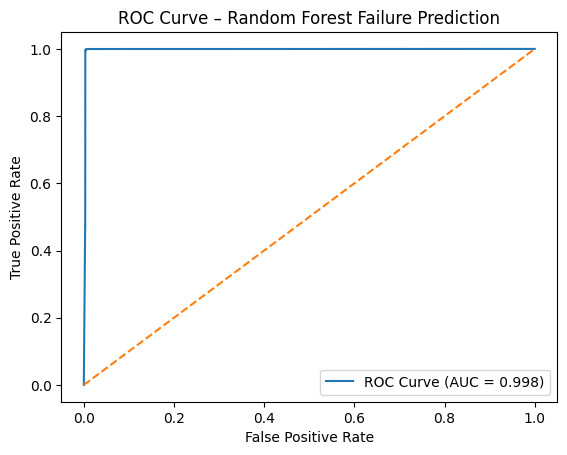

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest Failure Prediction')
plt.legend(loc='lower right')
plt.show()


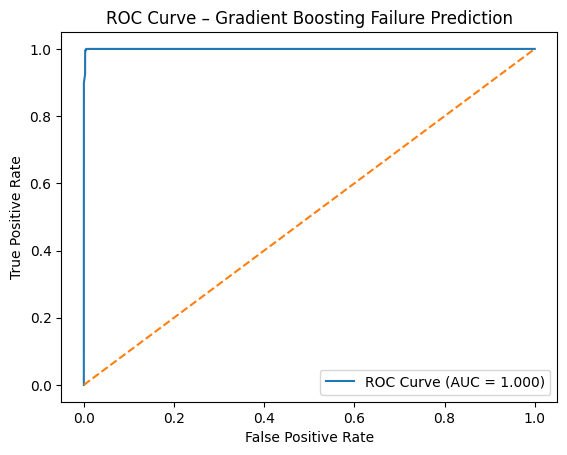

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, gb_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Gradient Boosting Failure Prediction')
plt.legend(loc='lower right')
plt.show()


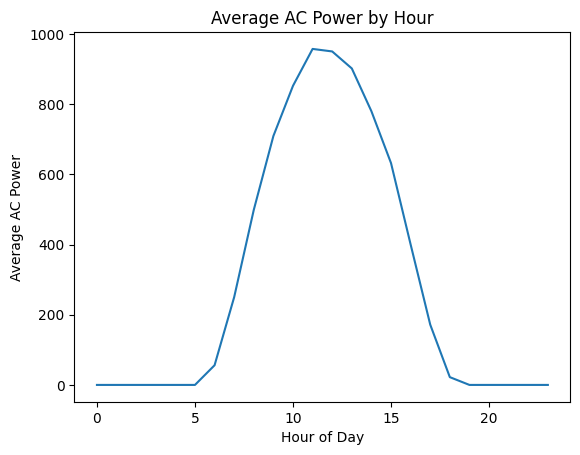

In [37]:
import matplotlib.pyplot as plt

df.groupby('hour')['AC_POWER'].mean().plot()
plt.xlabel("Hour of Day")
plt.ylabel("Average AC Power")
plt.title("Average AC Power by Hour")
plt.show()


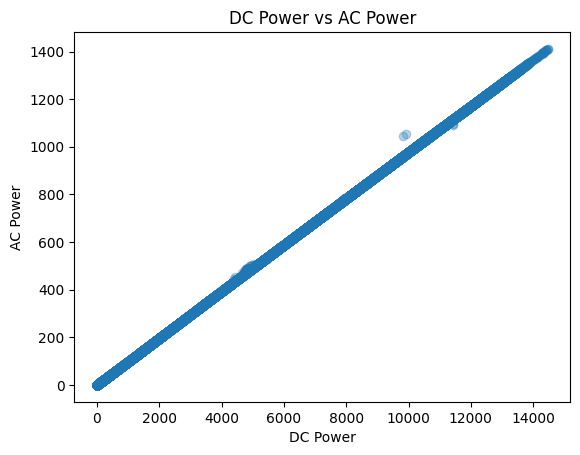

In [38]:
plt.figure()
plt.scatter(df['DC_POWER'], df['AC_POWER'], alpha=0.3)
plt.xlabel("DC Power")
plt.ylabel("AC Power")
plt.title("DC Power vs AC Power")
plt.show()


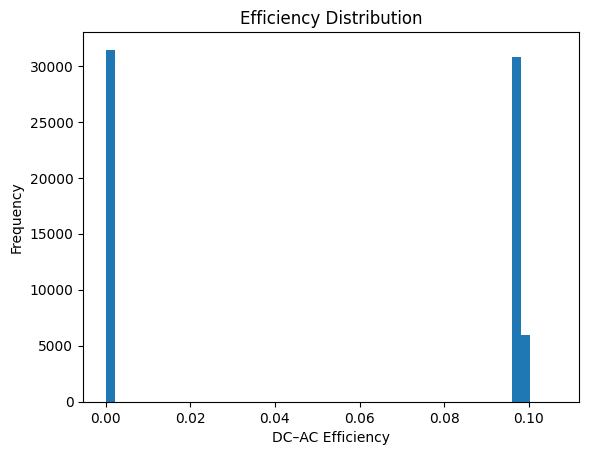

In [39]:
df['efficiency'] = df['AC_POWER'] / (df['DC_POWER'] + 1e-6)

plt.figure()
plt.hist(df['efficiency'], bins=50)
plt.xlabel("DC–AC Efficiency")
plt.ylabel("Frequency")
plt.title("Efficiency Distribution")
plt.show()


In [40]:
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importances)


          feature  importance
0        DC_POWER    0.666755
2            hour    0.221139
1      rolling_dc    0.109502
3             day    0.001522
5  SOURCE_KEY_ENC    0.000847
4           month    0.000235


In [41]:
df_test = df[df['DATE_TIME'] > split_date].copy()
df_test['predicted_failure'] = rf.predict(X_test)

downtime_events = df_test['predicted_failure'].sum()
power_loss_estimated = df_test[df_test['predicted_failure'] == 1]['DC_POWER'].sum()

print("Estimated Failure Events:", downtime_events)
print("Estimated Power Loss (kW):", power_loss_estimated)


Estimated Failure Events: 7253
Estimated Power Loss (kW): 250740.87500049


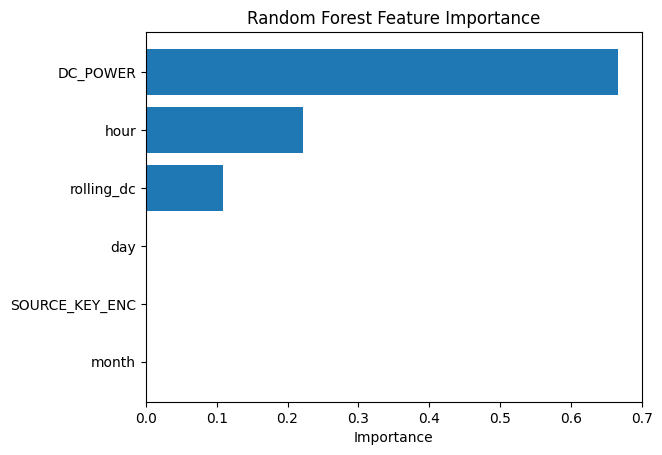

In [42]:
import pandas as pd

importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance')

plt.figure()
plt.barh(importances['feature'], importances['importance'])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()


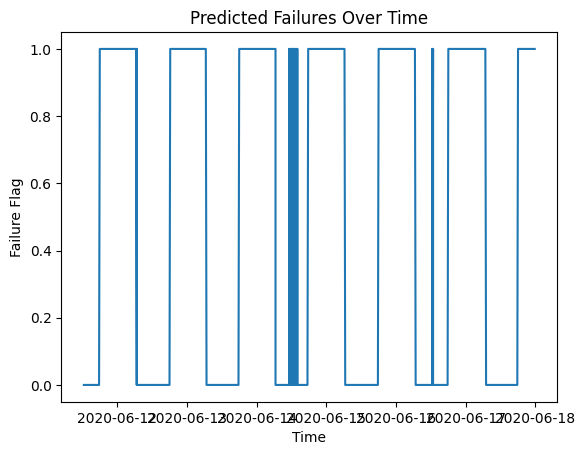

In [43]:
df_test['predicted_failure'] = rf.predict(X_test)

plt.figure()
plt.plot(df_test['DATE_TIME'], df_test['predicted_failure'])
plt.xlabel("Time")
plt.ylabel("Failure Flag")
plt.title("Predicted Failures Over Time")
plt.show()
